In [1]:
import uproot4
import numpy as np
import numba
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import mplhep as hep
#plt.style.use(hep.style.CMS)
plt.style.use(hep.style.DQ)

import matplotlib
plt.rcParams["text.usetex"] = False
# Overall - both left and right annotation
#hep.cms.label("", data=False, lumi=50, year=2017)
# Just experiment label and <text> such as 'Preliminary' or 'Simulation'
#hep.cms.text("Preliminary")

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
# import matplotlib.pylab as pylab
# params = {'legend.fontsize': 'small',
#          'axes.labelsize': 'large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'medium',
#          'ytick.labelsize':'medium'}
# pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName="Truth"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "event_weight": ak.zip({
                                'weight': dq_dict_ak1['weight']
                        }),
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
                        "reco_dimuon": ak.zip({
                                            "mass": dq_dict_ak1["dimuon_mass"],
                                            "x": dq_dict_ak1["dimuon_x_vtx"],
                                            "y": dq_dict_ak1["dimuon_y_vtx"],
                                            "z": dq_dict_ak1["dimuon_z_vtx"],
                                            "chisq": dq_dict_ak1["dimuon_chisq"],
                            
                        }),
                        "truth_dimuon":ak.zip({
                                            "mass": dq_dict_ak1['truthdimuon_mass'],
                                            "x": dq_dict_ak1['truthdimuon_x_vtx'],
                                            "y": dq_dict_ak1['truthdimuon_y_vtx'],
                                            "z": dq_dict_ak1['truthdimuon_z_vtx'],
                                            "px": dq_dict_ak1['truthdimuon_px'],
                                            "py": dq_dict_ak1['truthdimuon_py'],
                                            "pz": dq_dict_ak1['truthdimuon_pz'],
                            
                        })
                       }, depth_limit=1)
    return dq_events


######## READ EVENTS
sample_dir = "/mnt/T2_US_MIT/hadoop/mitgroups/DarkQuest/dhoang/Aprime_Muons_Scan_08_03_2022/"
filename = "/mnt/T2_US_MIT/hadoop/mitgroups/DarkQuest/dhoang/Aprime_Muons_Scan_08_03_2022/Brem_0.950000_z500_600_eps_-4.6.root"
dq_events = getData(filename, treeName = 'Events')

Saving plots to:  plot/21-03-2022


In [26]:
!ls

Apmuons_eff_1_patricknewsetup.ipynb
Apmuons_eff_1_patricknewsetup_NoDriftChamber.ipynb
Apmuons_eff_2_patricknewsetup_DriftChamber.ipynb
Apmuons_eff_3_patricknewsetup_Newtrigger.ipynb
Apmuons_eff_4_patricknewsetup_Electrons.ipynb
Apmuons_tracking_3_acceptanceScan_trigger.ipynb
DP_Tracking_Explore_1.ipynb
DPmuons_resolution_1.ipynb
DQ.png
DQPlotFormat.ipynb
DQ_Plots.ipynb
MuonEff_default_extraoff_eflagoff.ipynb
calculate_z_vtx.py
environment.yml
mplhep
plot


In [51]:
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

Error for parameter esimations:  [0.07258835 0.01629308 0.01397133]
Standard deviation (fit) is 0.3252449380016363
Mean (fit) is 0.09866174844913451


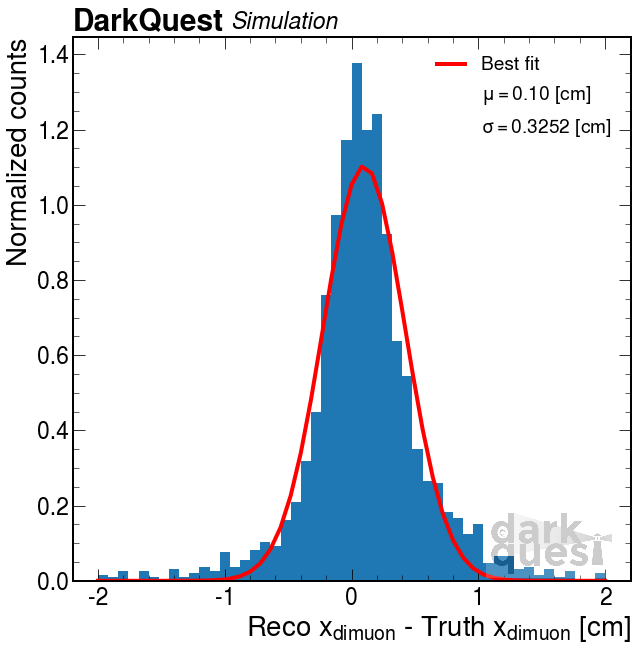

In [2]:
def reco_find_residual(dq_events):
    
    
    #Tracks selection
    reco_select = ak.count(dq_events["reco_dimuon"].x, axis = 1) == 1
    
    truth_x = ak.flatten(dq_events["truth_dimuon"].x[reco_select])
    reco_x = ak.flatten(dq_events["reco_dimuon"].x[reco_select])
    
    #filter nana
    truth_x = truth_x[~np.isnan(reco_x)]
    reco_x = reco_x[~np.isnan(reco_x)]
   
    #Calculate the residual
    residual = reco_x - truth_x
    
    #print(np.mean(ak.flatten(reco_mass)))

    return np.asarray(residual), ak.mean(reco_x)

def gaussian_fit(residual,
                 mean,
                 plot_bins = 50,
                 plot_range = (-2, 2),
                 p_guess=[0.05, 0, 10],
                 residual_label = r'Reco $x_{dimuon}$ - Truth $x_{dimuon}$ [cm]'):
    
    #Plot and fit
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    
    ## Gaussian fit
    ## Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False,
                           p0=p_guess)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$ [cm]'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [cm]'%abs(popt[2]))
    #plt.plot([],[], 'none', label=r'$<m>=%.2f$ [GeV]'%mean)
    #plt.plot([],[], 'none', label=r'$\sigma/<m>=%.4f$'%(abs(popt[2])/mean))
    
    #Label the axes
    plt.xlabel(residual_label)
    plt.ylabel('Normalized counts')

    plt.legend()

def plot_mass_resolution(dq_events):
    
    x_residual, x_mean = reco_find_residual(dq_events)
    gaussian_fit(x_residual, x_mean)

    
fig, ax = plt.subplots()
plot_mass_resolution(dq_events)
hep.dq.text("Simulation")
hep.dq.logo(ax, loc ='bottom right')
#plt.savefig(save_path+"DP_x_res.pdf", bbox_inches='tight')



# im = plt.imread("DQ.png")
# print(xmin, xmax, ymin, ymax)
# plt.imshow(im,
#            aspect ='auto',
#            extent = [xmin, xmin+abs(xmin)/2, ymax-abs(ymax)/2, ymax],
#            alpha = 0.06)
# plot_mass_resolution(dq_events)

# Annotate the 2nd position with another image (a Grace Hopper portrait)
# xmin, xmax, ymin, ymax = plt.axis()
# arr_img = plt.imread('DQ.png')
# # with get_sample_data("grace_hopper.jpg") as file:
# #     arr_img = plt.imread(file)

# imagebox = OffsetImage(arr_img, zoom=0.1, alpha=0.2)
# imagebox.image.axes = ax
# xy = (xmax-0.6, ymin+0.1)
# ab = AnnotationBbox(imagebox, xy, frameon = False)

# ax.add_artist(ab)




plt.show()

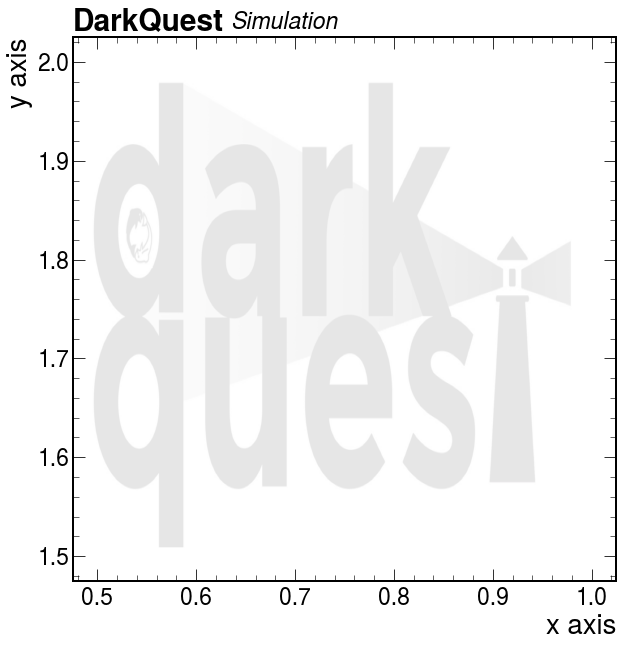

In [14]:
plt.plot([1,2],[3,4])
hep.dq.text("Simulation")

im = plt.imread("DQ.png")
xmin, xmax, ymin, ymax = plt.axis()
plt.imshow(im, extent = [xmin/2, xmax/2, ymin/2, ymax/2], alpha = 0.1)

plt.xlabel('x axis')
plt.ylabel('y axis')
plt.show()